In [1]:
# Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine,reflect=True)

In [4]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
station  = base.classes.station
measurement = base.classes.measurement

# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## 1. Percipitation analysis

In [6]:
# Get the latest date
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
latest_date

('2017-08-23',)

In [7]:
# Get the year ago date
ya_date = dt.date(2017,8,23) - dt.timedelta(days=365)

# Query the data of the specific period
mear_result = session.query(measurement.date,measurement.prcp).filter(measurement.date > ya_date).all()

# Save them into a dataframe
date = [mear_result[i][0] for i in range(len(mear_result))]
per_score = [mear_result[i][1] for i in range(len(mear_result))]
mear_df = pd.DataFrame(data = {"date":date,"per_score":per_score})
mear_df.head()

,date,per_score
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01


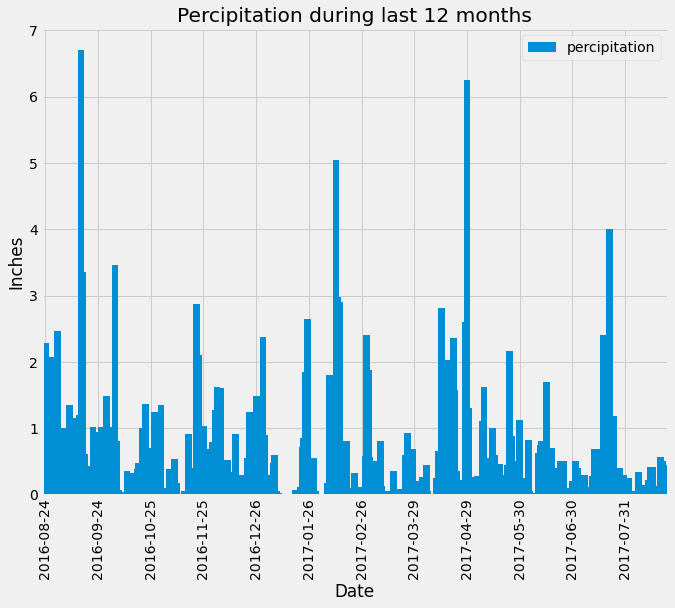

In [8]:
# plot the percipitation results 
plot_df = mear_df.groupby("date").max().reset_index("date").rename(columns={"per_score":"percipitation"})

# generate xticks to show (otherwise there are too many value)
xticks = []
i = 0
while i <= len(plot_df["date"]):
    xticks.append(plot_df["date"][i])
    i = i+31

# codes for plotting figures
plot_df.plot.bar(by="date",rot=90,figsize=(10,8),width=4)
plt.xticks(np.arange(0,365,step=31),xticks)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Percipitation during last 12 months")
plt.show()

In [9]:
# Get summary statistics of percipitation data
mear_df["per_score"].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: per_score, dtype: float64

## 2. Station Analysis

In [10]:
# Explore the tables
inspector = inspect(engine)
station_col = inspector.get_columns("station")
for col1 in station_col:
    print(col1["name"],col1["type"])

mear_col = inspector.get_columns("measurement")
for col2 in mear_col:
    print(col2["name"],col2["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Design a query to show how many stations are available in this dataset?

session.query(func.count(station.station)).all()

[(9,)]

In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?

station_query = session.query(measurement.station).all()

# Save them into a dataframe and then explore the most active stations
station = [station_query[i][0] for i in range(len(station_query))]
station_df = pd.DataFrame(data = {"station":station})
station_df.value_counts()

station    
USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
dtype: int64

In [13]:
# The most active station is USC00519397
# query its highest, average, lowest temperature

session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
                filter(measurement.station == "USC00519397" ).all()

[(56.0, 87.0, 74.55323054331865)]

In [14]:
# Query the last 12 months of temperature observation data for station USC00519397

tob_data = session.query(measurement.tobs).filter(measurement.station == "USC00519397").filter(measurement.date > ya_date).all()

tob = [tob_data[i][0] for i in range(len(tob_data))]
tob_df = pd.DataFrame(data = {"tob":tob})
tob_df.head()

,tob
0,79.0
1,80.0
2,79.0
3,77.0
4,78.0


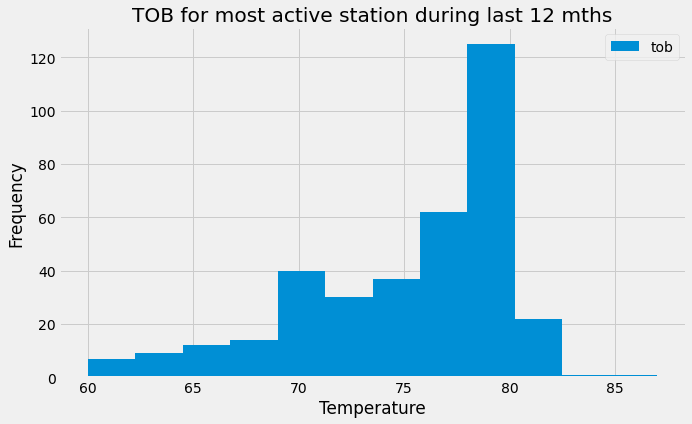

In [15]:
# plot the results as a histogram

tob_df.plot.hist(bins = 12,figsize=(10,6))
plt.xlabel("Temperature")
plt.title("TOB for most active station during last 12 mths")
plt.show()